# Model v1

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef

def analyze_uncensoring_methods(csv_file_path, metric_name, max_depth=4, test_size=0.2, random_state=42):
    """
    Complete analysis pipeline for uncensoring method selection using decision trees.
    
    Parameters:
    csv_file_path : str
        Path to the CSV file containing the uncensoring data
    metric_name : str
        The metric to use for finding the best method (e.g., 'weighted_mae_0', 'accuracy', 'mse', etc.)
    max_depth : int, default=4
        Maximum depth of the decision tree
    test_size : float, default=0.2
        Proportion of dataset to include in the test split
    random_state : int, default=42
        Random state for reproducibility
    
    Returns:
    dict
        Dictionary containing:
        - 'classifier': Trained DecisionTreeClassifier
        - 'X_train', 'X_test', 'y_train', 'y_test': Train/test splits
        - 'y_pred': Predictions on test set
        - 'df': Full dataframe with best_method column
        - 'results': Dictionary with all evaluation metrics
    """
    
    # Read the data
    df = pd.read_csv(csv_file_path)
    
    # Define the methods
    methods = ['Bayesian_POS', 'N1', 'N2', 'N3', 'EM', 'PD', 'Nahmias', 'Conrad', 
               'Baseline', 'Agrawal']
    
    # Create the column names for the specified metric
    metric_cols = [f"{method}_{metric_name}" for method in methods]
    
    # Check if all metric columns exist in the dataframe
    missing_cols = [col for col in metric_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in dataframe: {missing_cols}")
    
    # Find the best method for each row based on the metric
    # For metrics like MAE, MSE (lower is better), use idxmin
    # For metrics like accuracy (higher is better), use idxmax
    if any(keyword in metric_name.lower() for keyword in ['mae', 'mse', 'error', 'loss']):
        df[f'best_method_{metric_name}'] = df[metric_cols].idxmin(axis=1)
        optimization_direction = "minimize"
    else:
        # For accuracy and similar metrics where higher is better
        df[f'best_method_{metric_name}'] = df[metric_cols].idxmax(axis=1)
        optimization_direction = "maximize"
    
    # Map the column names back to method names
    col_to_method_map = {f"{method}_{metric_name}": method for method in methods}
    df[f'best_method_{metric_name}'] = df[f'best_method_{metric_name}'].map(col_to_method_map)
    
    # Define feature columns
    feature_cols = [
        'data_sparsity', 'stockout_rate', 'verkauf_variance', 'verkauf_mean', 
        'coefficient_of_variation', 'unique_quantities', 'variance_to_mean_ratio', 
        'verkauf_autocorr', 'adi', 'Gesamtzeilen', 'KSR_Count', 'TSR_Count', 
        'KSR_TSR_Summe', 'KSR_Anteil', 'TSR_Anteil', 'KSR_TSR_Anteil'
    ]
    
    # Check if all feature columns exist
    missing_features = [col for col in feature_cols if col not in df.columns]
    if missing_features:
        raise ValueError(f"Missing feature columns in dataframe: {missing_features}")
    
    # Prepare X and y
    X = df[feature_cols]
    y = df[f'best_method_{metric_name}']
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Initialize and train the classifier
    clf = DecisionTreeClassifier(random_state=random_state, max_depth=max_depth)
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # ============================================================================
    # Evaluation and Analysis
    # ============================================================================
    
    print(f"UNCENSORING METHOD ANALYSIS - {metric_name.upper()}")
    print("="*80)
    print(f"Dataset: {csv_file_path}")
    print(f"Metric: {metric_name} ({optimization_direction})")
    print(f"Sample size: {len(df)} observations")
    print(f"Train/Test split: {len(X_train)}/{len(X_test)}")
    
    print(f"\nCLASSIFICATION PERFORMANCE")
    print("="*80)
    print(classification_report(y_test, y_pred))
    
    # Calculate Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    
    # MCC interpretation
    if mcc > 0.8:
        interpretation = "Very Strong"
    elif mcc > 0.6:
        interpretation = "Strong" 
    elif mcc > 0.4:
        interpretation = "Moderate"
    elif mcc > 0.2:
        interpretation = "Weak"
    elif mcc > 0:
        interpretation = "Very Weak"
    elif mcc == 0:
        interpretation = "No Correlation"
    else:
        interpretation = "Negative Correlation"
    
    print(f"Correlation Strength: {interpretation}")
    
    # ============================================================================
    # Metric-based Evaluation
    # ============================================================================
    
    print(f"\n{metric_name.upper()} COMPARISON RESULTS")
    print("="*80)
    
    # Get the test set indices to align with original dataframe
    test_indices = X_test.index
    
    # 1. Perfect Strategy: Always pick the best method
    perfect_metric_values = []
    for idx in test_indices:
        best_method = df.loc[idx, f'best_method_{metric_name}']
        best_metric_value = df.loc[idx, best_method + f'_{metric_name}']
        perfect_metric_values.append(best_metric_value)
    perfect_avg_metric = np.mean(perfect_metric_values)
    
    # 2. Decision Tree Strategy: Use classifier predictions
    dt_metric_values = []
    for i, idx in enumerate(test_indices):
        predicted_method = y_pred[i]
        predicted_metric_value = df.loc[idx, predicted_method + f'_{metric_name}']
        dt_metric_values.append(predicted_metric_value)
    dt_avg_metric = np.mean(dt_metric_values)
    
    # 3. Most Common Method Strategy
    most_common_method = y_train.mode()[0]  # Use training set to determine most common
    common_metric_values = []
    for idx in test_indices:
        common_metric_value = df.loc[idx, most_common_method + f'_{metric_name}']
        common_metric_values.append(common_metric_value)
    common_avg_metric = np.mean(common_metric_values)
    
    # 4. Best Overall Method Strategy (best average metric across all data)
    # Calculate average metric for each method across all data
    method_avg_metrics = {}
    for method in methods:
        method_avg_metrics[method] = df[method + f'_{metric_name}'].mean()
    
    if optimization_direction == "minimize":
        best_overall_method = min(method_avg_metrics, key=method_avg_metrics.get)
    else:
        best_overall_method = max(method_avg_metrics, key=method_avg_metrics.get)
    
    best_overall_metric_values = []
    for idx in test_indices:
        best_overall_metric_value = df.loc[idx, best_overall_method + f'_{metric_name}']
        best_overall_metric_values.append(best_overall_metric_value)
    best_overall_avg_metric = np.mean(best_overall_metric_values)
    
    # Print results
    print(f"1. Perfect Strategy:        {perfect_avg_metric:.6f}")
    print(f"2. Decision Tree Classifier:         {dt_avg_metric:.6f}")
    print(f"3. Most Common Method ({most_common_method}):  {common_avg_metric:.6f}")
    print(f"4. Best Overall Method ({best_overall_method}):      {best_overall_avg_metric:.6f}")
    
    # ============================================================================
    # Performance Analysis
    # ============================================================================
    
    print(f"\nPERFORMACE ANALYSIS")
    print("="*80)
    
    if optimization_direction == "minimize":
        # For metrics where lower is better
        dt_vs_perfect = (dt_avg_metric / perfect_avg_metric - 1) * 100
        dt_vs_common = (common_avg_metric / dt_avg_metric - 1) * 100
        dt_vs_best_overall = (best_overall_avg_metric / dt_avg_metric - 1) * 100
        
        print(f"Decision Tree vs Perfect:            +{dt_vs_perfect:.2f}% worse")
        print(f"Decision Tree vs Most Common:        {dt_vs_common:+.2f}% better" if dt_vs_common > 0 else f"Decision Tree vs Most Common:        {dt_vs_common:.2f}% worse")
        print(f"Decision Tree vs Best Overall:       {dt_vs_best_overall:+.2f}% better" if dt_vs_best_overall > 0 else f"Decision Tree vs Best Overall:       {dt_vs_best_overall:.2f}% worse")
    else:
        # For metrics where higher is better
        dt_vs_perfect = (dt_avg_metric / perfect_avg_metric - 1) * 100
        dt_vs_common = (dt_avg_metric / common_avg_metric - 1) * 100
        dt_vs_best_overall = (dt_avg_metric / best_overall_avg_metric - 1) * 100
        
        print(f"Decision Tree vs Perfect:            {dt_vs_perfect:.2f}% worse")
        print(f"Decision Tree vs Most Common:        {dt_vs_common:+.2f}% better" if dt_vs_common > 0 else f"Decision Tree vs Most Common:        {dt_vs_common:.2f}% worse")
        print(f"Decision Tree vs Best Overall:       {dt_vs_best_overall:+.2f}% better" if dt_vs_best_overall > 0 else f"Decision Tree vs Best Overall:       {dt_vs_best_overall:.2f}% worse")
    
    # ============================================================================
    # Method Distribution Analysis
    # ============================================================================
    
    print(f"\nMETHOD SELECTION FREQUENCY (Test Set)")
    print("="*80)
    print("Decision Tree Predictions:")
    pred_counts = pd.Series(y_pred).value_counts().sort_index()
    for method, count in pred_counts.items():
        print(f"  {method}: {count} ({count/len(y_pred)*100:.1f}%)")
    
    print(f"\nActual Best Methods:")
    actual_counts = y_test.value_counts().sort_index()
    for method, count in actual_counts.items():
        print(f"  {method}: {count} ({count/len(y_test)*100:.1f}%)")
    
    print(f"\nOverall Method Performance (Average {metric_name} across all data):")
    print("="*80)
    if optimization_direction == "minimize":
        sorted_methods = sorted(method_avg_metrics.items(), key=lambda x: x[1])
    else:
        sorted_methods = sorted(method_avg_metrics.items(), key=lambda x: x[1], reverse=True)
    
    for method, avg_metric in sorted_methods:
        print(f"  {method}: {avg_metric:.6f}")
    
    # Decision tree accuracy in terms of picking the exact best method
    exact_matches = sum(y_pred == y_test)
    accuracy = exact_matches / len(y_test)
    print(f"\nDecision Tree Accuracy (Exact Best Method): {accuracy:.3f} ({exact_matches}/{len(y_test)})")
    
    # Prepare results dictionary
    results = {
        'perfect_avg_metric': perfect_avg_metric,
        'dt_avg_metric': dt_avg_metric,
        'common_avg_metric': common_avg_metric,
        'best_overall_avg_metric': best_overall_avg_metric,
        'most_common_method': most_common_method,
        'best_overall_method': best_overall_method,
        'mcc': mcc,
        'accuracy': accuracy,
        'method_avg_metrics': method_avg_metrics,
        'optimization_direction': optimization_direction
    }
    
    return {
        'classifier': clf,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred': y_pred,
        'df': df,
        'results': results
    }

# Model v2 (with/without resampling)

In [7]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

def analyze_uncensoring_methods(csv_file_path, metric_name, max_depth=4, min_samples_split=2, 
                               min_samples_leaf=1, max_leaf_nodes=None, min_weight_fraction_leaf=0.0,
                               test_size=0.2, random_state=42, apply_resampling=False, resampling_params=None):
    """
    Complete analysis pipeline for uncensoring method selection using decision trees.
    
    Parameters:
    -----------
    csv_file_path : str
        Path to the CSV file containing the uncensoring data
    metric_name : str
        The metric to use for finding the best method (e.g., 'weighted_mae_0', 'accuracy', 'mse', etc.)
    max_depth : int, default=4
        Maximum depth of the decision tree
    min_samples_split : int or float, default=2
        The minimum number of samples required to split an internal node
    min_samples_leaf : int or float, default=1
        The minimum number of samples required to be at a leaf node
    max_leaf_nodes : int, default=None
        Grow a tree with max_leaf_nodes in best-first fashion
    min_weight_fraction_leaf : float, default=0.0
        The minimum weighted fraction of the sum total of weights required to be at a leaf node
    test_size : float, default=0.2
        Proportion of dataset to include in the test split
    random_state : int, default=42
        Random state for reproducibility
    apply_resampling : bool, default=False
        Whether to apply resampling techniques to balance the training data
    resampling_params : dict, optional
        Parameters for resampling. If None, uses default values:
        {
            'min_class_size': 6,
            'majority_class_limit': 4000,
            'use_smote': True
        }
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'classifier': Trained DecisionTreeClassifier
        - 'X_train', 'X_test', 'y_train', 'y_test': Train/test splits
        - 'y_pred': Predictions on test set
        - 'df': Full dataframe with best_method column
        - 'results': Dictionary with all evaluation metrics
        - 'resampling_info': Information about resampling if applied
    """
    
    # Set default resampling parameters
    if resampling_params is None:
        resampling_params = {
            'min_class_size': 6,
            'majority_class_limit': 4000,
            'use_smote': True
        }
    
    # Read the data
    df = pd.read_csv(csv_file_path)
    df = df[df['laenge'] >= 5]
    
    # Define the methods
    methods = ['Bayesian_POS', 'N1', 'N2', 'N3', 'EM', 'PD', 'Nahmias', 'Conrad', 
               'Baseline', 'Agrawal']
    
    # Create the column names for the specified metric
    metric_cols = [f"{method}_{metric_name}" for method in methods]
    
    # Check if all metric columns exist in the dataframe
    missing_cols = [col for col in metric_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in dataframe: {missing_cols}")
    
    # Find the best method for each row based on the metric
    # For metrics like MAE, MSE (lower is better), use idxmin
    # For metrics like accuracy (higher is better), use idxmax
    if any(keyword in metric_name.lower() for keyword in ['mae', 'mse', 'error', 'loss']):
        df[f'best_method_{metric_name}'] = df[metric_cols].idxmin(axis=1)
        optimization_direction = "minimize"
    else:
        # For accuracy and similar metrics where higher is better
        df[f'best_method_{metric_name}'] = df[metric_cols].idxmax(axis=1)
        optimization_direction = "maximize"
    
    # Map the column names back to method names
    col_to_method_map = {f"{method}_{metric_name}": method for method in methods}
    df[f'best_method_{metric_name}'] = df[f'best_method_{metric_name}'].map(col_to_method_map)
    
    # Define feature columns
    feature_cols = [
        'data_sparsity', 'stockout_rate', 'verkauf_variance', 'verkauf_mean', 
        'coefficient_of_variation', 'unique_quantities', 'variance_to_mean_ratio', 
        'verkauf_autocorr', 'adi', 'Gesamtzeilen', 'KSR_Count', 'TSR_Count', 
        'KSR_TSR_Summe', 'KSR_Anteil', 'TSR_Anteil', 'KSR_TSR_Anteil'
    ]
    
    # Check if all feature columns exist
    missing_features = [col for col in feature_cols if col not in df.columns]
    if missing_features:
        raise ValueError(f"Missing feature columns in dataframe: {missing_features}")
    
    # Prepare X and y
    X = df[feature_cols]
    y = df[f'best_method_{metric_name}']
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # ============================================================================
    # RESAMPLING SECTION
    # ============================================================================
    
    resampling_info = {'applied': False}
    
    if apply_resampling:
        print(f"\nRESAMPLING ANALYSIS")
        print("="*80)
        
        # Analyze class distribution before resampling
        y_counts = Counter(y_train)
        print('Class distribution before resampling:')
        sorted_counts = sorted(y_counts.items(), key=lambda item: -item[1])
        for class_name, count in sorted_counts:
            print(f"  {class_name}: {count} samples ({count/len(y_train)*100:.1f}%)")
        
        # Identify classes that need resampling
        small_classes = [cls for cls, count in y_counts.items() 
                        if count < resampling_params['min_class_size']]
        majority_class = max(y_counts, key=y_counts.get)
        
        print(f"\nResampling strategy:")
        print(f"  Small classes (< {resampling_params['min_class_size']} samples): {small_classes}")
        print(f"  Majority class: {majority_class} ({y_counts[majority_class]} samples)")
        
        # Create resampling strategies
        random_sampling_strategy = {cls: resampling_params['min_class_size'] for cls in small_classes}
        under_sampling_strategy = {majority_class: resampling_params['majority_class_limit']}
        
        # Build resampling pipeline
        pipeline_steps = []
        
        # Step 1: Under-sampling (if majority class is too large)
        if y_counts[majority_class] > resampling_params['majority_class_limit']:
            pipeline_steps.append(('under', RandomUnderSampler(
                sampling_strategy=under_sampling_strategy, 
                random_state=random_state
            )))
            print(f"  Under-sampling {majority_class} to {resampling_params['majority_class_limit']} samples")
        
        # Step 2: Random over-sampling (for very small classes)
        if small_classes:
            pipeline_steps.append(('random', RandomOverSampler(
                sampling_strategy=random_sampling_strategy, 
                random_state=random_state
            )))
            print(f"  Over-sampling small classes to {resampling_params['min_class_size']} samples each")
        
        # Step 3: SMOTE (for final balancing)
        if resampling_params['use_smote']:
            pipeline_steps.append(('smote', SMOTE(
                sampling_strategy='auto', 
                random_state=random_state
            )))
            print(f"  Applying SMOTE for synthetic sample generation")
        
        # Apply resampling if any steps are needed
        if pipeline_steps:
            sampler = Pipeline(steps=pipeline_steps)
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)
            
            # Analyze class distribution after resampling
            y_counts_after = Counter(y_train_resampled)
            print(f"\nClass distribution after resampling:")
            sorted_counts_after = sorted(y_counts_after.items(), key=lambda item: -item[1])
            for class_name, count in sorted_counts_after:
                print(f"  {class_name}: {count} samples ({count/len(y_train_resampled)*100:.1f}%)")
            
            # Update training data
            X_train, y_train = X_train_resampled, y_train_resampled
            
            # Store resampling information
            resampling_info = {
                'applied': True,
                'original_distribution': dict(y_counts),
                'resampled_distribution': dict(y_counts_after),
                'original_size': len(y_counts),
                'resampled_size': len(y_counts_after),
                'pipeline_steps': [step[0] for step in pipeline_steps],
                'parameters': resampling_params
            }
            
            print(f"\nResampling completed:")
            print(f"  Original training size: {len(y_counts)} → {len(y_counts_after)} samples")
            print(f"  Size change: {(len(y_counts_after)/len(y_counts)-1)*100:+.1f}%")
        else:
            print("  No resampling needed - class distribution is already balanced")
    
    # ============================================================================
    # MODEL TRAINING
    # ============================================================================
    
    # Initialize and train the classifier
    clf = DecisionTreeClassifier(
        random_state=random_state, 
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes,
        min_weight_fraction_leaf=min_weight_fraction_leaf
    )
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # ============================================================================
    # Evaluation and Analysis
    # ============================================================================
    
    print(f"\nUNCENSORING METHOD ANALYSIS - {metric_name.upper()}")
    print("="*80)
    print(f"Dataset: {csv_file_path}")
    print(f"Metric: {metric_name} ({optimization_direction})")
    print(f"Sample size: {len(df)} observations")
    if apply_resampling and resampling_info['applied']:
        print(f"Train/Test split: {len(X_train)} (resampled)/{len(X_test)}")
        print(f"Original train size: {resampling_info['original_size']}")
    else:
        print(f"Train/Test split: {len(X_train)}/{len(X_test)}")
    
    print(f"\nCLASSIFICATION PERFORMANCE")
    print("="*80)
    print(classification_report(y_test, y_pred))
    
    # Calculate Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    
    # MCC interpretation
    if mcc > 0.8:
        interpretation = "Very Strong"
    elif mcc > 0.6:
        interpretation = "Strong" 
    elif mcc > 0.4:
        interpretation = "Moderate"
    elif mcc > 0.2:
        interpretation = "Weak"
    elif mcc > 0:
        interpretation = "Very Weak"
    elif mcc == 0:
        interpretation = "No Correlation"
    else:
        interpretation = "Negative Correlation"
    
    print(f"Correlation Strength: {interpretation}")
    
    # ============================================================================
    # Metric-based Evaluation
    # ============================================================================
    
    print(f"\n{metric_name.upper()} COMPARISON RESULTS")
    print("="*80)
    
    # Get the test set indices to align with original dataframe
    test_indices = X_test.index
    
    # 1. Perfect Strategy: Always pick the best method
    perfect_metric_values = []
    for idx in test_indices:
        best_method = df.loc[idx, f'best_method_{metric_name}']
        best_metric_value = df.loc[idx, best_method + f'_{metric_name}']
        perfect_metric_values.append(best_metric_value)
    perfect_avg_metric = np.mean(perfect_metric_values)
    
    # 2. Decision Tree Strategy: Use classifier predictions
    dt_metric_values = []
    for i, idx in enumerate(test_indices):
        predicted_method = y_pred[i]
        predicted_metric_value = df.loc[idx, predicted_method + f'_{metric_name}']
        dt_metric_values.append(predicted_metric_value)
    dt_avg_metric = np.mean(dt_metric_values)
    
    # 3. Most Common Method Strategy
    # Use original y_train to avoid bias from resampling
    original_y_train = df.loc[X_train.index, f'best_method_{metric_name}'] if resampling_info['applied'] else y_train
    most_common_method = original_y_train.mode()[0]
    common_metric_values = []
    for idx in test_indices:
        common_metric_value = df.loc[idx, most_common_method + f'_{metric_name}']
        common_metric_values.append(common_metric_value)
    common_avg_metric = np.mean(common_metric_values)
    
    # 4. Best Overall Method Strategy (best average metric across all data)
    # Calculate average metric for each method across all data
    method_avg_metrics = {}
    for method in methods:
        method_avg_metrics[method] = df[method + f'_{metric_name}'].mean()
    
    if optimization_direction == "minimize":
        best_overall_method = min(method_avg_metrics, key=method_avg_metrics.get)
    else:
        best_overall_method = max(method_avg_metrics, key=method_avg_metrics.get)
    
    best_overall_metric_values = []
    for idx in test_indices:
        best_overall_metric_value = df.loc[idx, best_overall_method + f'_{metric_name}']
        best_overall_metric_values.append(best_overall_metric_value)
    best_overall_avg_metric = np.mean(best_overall_metric_values)
    
    # Print results
    print(f"1. Perfect Strategy:        {perfect_avg_metric:.6f}")
    print(f"2. Decision Tree Classifier:         {dt_avg_metric:.6f}")
    print(f"3. Most Common Method ({most_common_method}):  {common_avg_metric:.6f}")
    print(f"4. Best Overall Method ({best_overall_method}):      {best_overall_avg_metric:.6f}")
    
    # ============================================================================
    # Performance Analysis
    # ============================================================================
    
    print(f"\nPERFORMANCE ANALYSIS")
    print("="*80)
    
    if optimization_direction == "minimize":
        # For metrics where lower is better
        dt_vs_perfect = (dt_avg_metric / perfect_avg_metric - 1) * 100
        dt_vs_common = (common_avg_metric / dt_avg_metric - 1) * 100
        dt_vs_best_overall = (best_overall_avg_metric / dt_avg_metric - 1) * 100
        
        print(f"Decision Tree vs Perfect:            +{dt_vs_perfect:.2f}% worse")
        print(f"Decision Tree vs Most Common:        {dt_vs_common:+.2f}% better" if dt_vs_common > 0 else f"Decision Tree vs Most Common:        {dt_vs_common:.2f}% worse")
        print(f"Decision Tree vs Best Overall:       {dt_vs_best_overall:+.2f}% better" if dt_vs_best_overall > 0 else f"Decision Tree vs Best Overall:       {dt_vs_best_overall:.2f}% worse")
    else:
        # For metrics where higher is better
        dt_vs_perfect = (dt_avg_metric / perfect_avg_metric - 1) * 100
        dt_vs_common = (dt_avg_metric / common_avg_metric - 1) * 100
        dt_vs_best_overall = (dt_avg_metric / best_overall_avg_metric - 1) * 100
        
        print(f"Decision Tree vs Perfect:            {dt_vs_perfect:.2f}% worse")
        print(f"Decision Tree vs Most Common:        {dt_vs_common:+.2f}% better" if dt_vs_common > 0 else f"Decision Tree vs Most Common:        {dt_vs_common:.2f}% worse")
        print(f"Decision Tree vs Best Overall:       {dt_vs_best_overall:+.2f}% better" if dt_vs_best_overall > 0 else f"Decision Tree vs Best Overall:       {dt_vs_best_overall:.2f}% worse")
    
    # ============================================================================
    # Method Distribution Analysis
    # ============================================================================
    
    print(f"\nMETHOD SELECTION FREQUENCY (Test Set)")
    print("="*80)
    print("Decision Tree Predictions:")
    pred_counts = pd.Series(y_pred).value_counts().sort_index()
    for method, count in pred_counts.items():
        print(f"  {method}: {count} ({count/len(y_pred)*100:.1f}%)")
    
    print(f"\nActual Best Methods:")
    actual_counts = y_test.value_counts().sort_index()
    for method, count in actual_counts.items():
        print(f"  {method}: {count} ({count/len(y_test)*100:.1f}%)")
    
    print(f"\nOverall Method Performance (Average {metric_name} across all data):")
    print("="*80)
    if optimization_direction == "minimize":
        sorted_methods = sorted(method_avg_metrics.items(), key=lambda x: x[1])
    else:
        sorted_methods = sorted(method_avg_metrics.items(), key=lambda x: x[1], reverse=True)
    
    for method, avg_metric in sorted_methods:
        print(f"  {method}: {avg_metric:.6f}")
    
    # Decision tree accuracy in terms of picking the exact best method
    exact_matches = sum(y_pred == y_test)
    accuracy = exact_matches / len(y_test)
    print(f"\nDecision Tree Accuracy (Exact Best Method): {accuracy:.3f} ({exact_matches}/{len(y_test)})")
    
    # Prepare results dictionary
    results = {
        'perfect_avg_metric': perfect_avg_metric,
        'dt_avg_metric': dt_avg_metric,
        'common_avg_metric': common_avg_metric,
        'best_overall_avg_metric': best_overall_avg_metric,
        'most_common_method': most_common_method,
        'best_overall_method': best_overall_method,
        'mcc': mcc,
        'accuracy': accuracy,
        'method_avg_metrics': method_avg_metrics,
        'optimization_direction': optimization_direction
    }
    
    return {
        'classifier': clf,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred': y_pred,
        'df': df,
        'results': results,
        'resampling_info': resampling_info
    }


# Example usage functions for different scenarios
def run_without_resampling(csv_file_path, metric_name, **dt_params):
    """Run analysis without resampling (original behavior)"""
    return analyze_uncensoring_methods(csv_file_path, metric_name, apply_resampling=False, **dt_params)

def run_with_basic_resampling(csv_file_path, metric_name, **dt_params):
    """Run analysis with basic resampling using default parameters"""
    return analyze_uncensoring_methods(csv_file_path, metric_name, apply_resampling=True, **dt_params)

def run_with_custom_resampling(csv_file_path, metric_name, min_class_size=10, majority_limit=3000, use_smote=True, **dt_params):
    """Run analysis with custom resampling parameters"""
    resampling_params = {
        'min_class_size': min_class_size,
        'majority_class_limit': majority_limit,
        'use_smote': use_smote
    }
    return analyze_uncensoring_methods(csv_file_path, metric_name, 
                                     apply_resampling=True, 
                                     resampling_params=resampling_params,
                                     **dt_params)

# Overall Support Figures

In [8]:
import pandas as pd

df = pd.read_csv('dt_inputs/Uncensoring_DT_Input.csv')
df = df[df['laenge'] >= 5]

value_counts = df['best_method_weighted_mae_0'].value_counts()

print("Value counts for 'best_method_pinball_loss' column:")
print(value_counts)

Value counts for 'best_method_pinball_loss' column:
best_method_weighted_mae_0
N3          3796
Bayesian    1672
PD          1547
Conrad      1176
EM           845
Nahmias      824
Agrawal      468
Baseline     294
N1            47
N2            16
Name: count, dtype: int64


# Execution

In [9]:
# Usage
analysis = run_without_resampling(
    csv_file_path='dt_inputs/Uncensoring_DT_Input.csv',
    metric_name='weighted_mae_0',
    max_depth=7 # Different hyperparameters
)

# Access results
mae_classifier = analysis['classifier']
mae_results = analysis['results']


UNCENSORING METHOD ANALYSIS - WEIGHTED_MAE_0
Dataset: dt_inputs/Uncensoring_DT_Input.csv
Metric: weighted_mae_0 (minimize)
Sample size: 10685 observations
Train/Test split: 8548/2137

CLASSIFICATION PERFORMANCE
              precision    recall  f1-score   support

     Agrawal       0.17      0.03      0.04        39
    Baseline       0.00      0.00      0.00        42
Bayesian_POS       0.72      0.70      0.71       529
      Conrad       0.07      0.01      0.02       208
          EM       0.50      0.48      0.49       106
          N1       0.00      0.00      0.00         6
          N2       0.00      0.00      0.00         7
          N3       0.61      0.70      0.65       588
     Nahmias       0.48      0.65      0.55       384
          PD       0.66      0.81      0.73       228

    accuracy                           0.59      2137
   macro avg       0.32      0.34      0.32      2137
weighted avg       0.54      0.59      0.56      2137

Matthews Correlation Coeffici

/opt/anaconda3/envs/tum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Plotting + Further Analysis

FEATURE IMPORTANCE ANALYSIS
Feature Importance (Decision Tree):
                     feature  importance
3               verkauf_mean      0.6821
1              stockout_rate      0.1181
0              data_sparsity      0.1059
9               Gesamtzeilen      0.0216
2           verkauf_variance      0.0147
4   coefficient_of_variation      0.0128
8                        adi      0.0113
6     variance_to_mean_ratio      0.0083
7           verkauf_autocorr      0.0064
15            KSR_TSR_Anteil      0.0057
10                 KSR_Count      0.0035
5          unique_quantities      0.0034
12             KSR_TSR_Summe      0.0026
11                 TSR_Count      0.0018
13                KSR_Anteil      0.0011
14                TSR_Anteil      0.0009


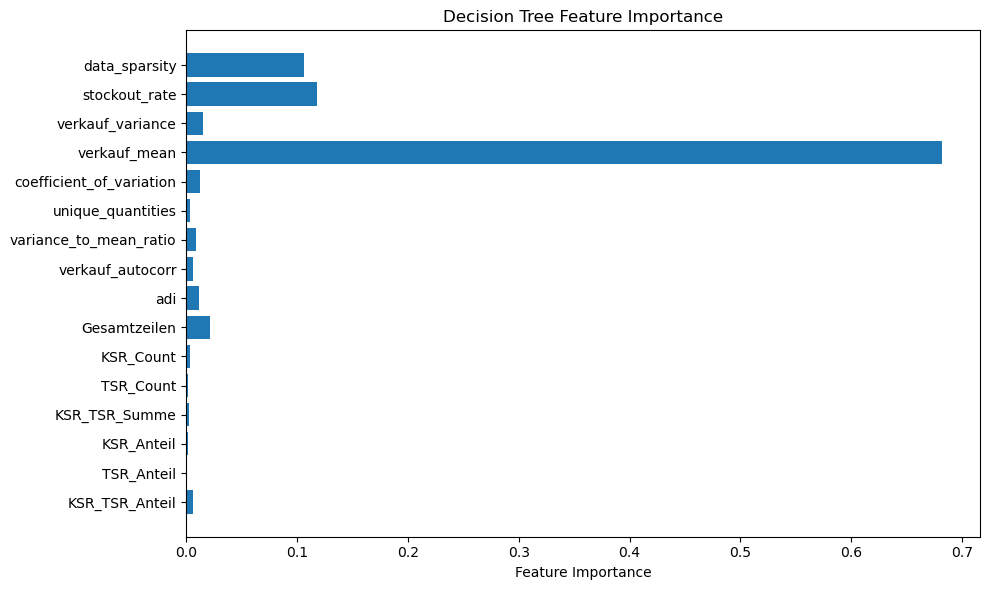


Calculating permutation importance...

Permutation Importance:
                     feature  importance_mean  importance_std
3               verkauf_mean           0.3259          0.0057
0              data_sparsity           0.1138          0.0050
1              stockout_rate           0.0384          0.0043
2           verkauf_variance           0.0119          0.0021
6     variance_to_mean_ratio           0.0091          0.0014
8                        adi           0.0088          0.0020
9               Gesamtzeilen           0.0072          0.0028
5          unique_quantities           0.0053          0.0014
7           verkauf_autocorr           0.0006          0.0020
15            KSR_TSR_Anteil           0.0006          0.0012
12             KSR_TSR_Summe           0.0006          0.0007
4   coefficient_of_variation           0.0005          0.0009
10                 KSR_Count           0.0003          0.0014
13                KSR_Anteil           0.0001          0.0002
14    

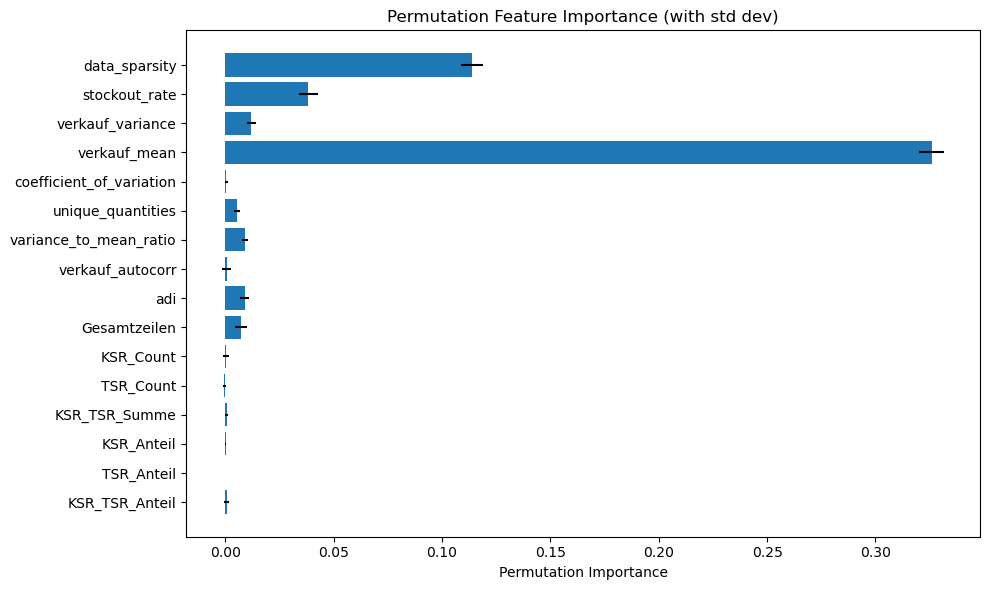

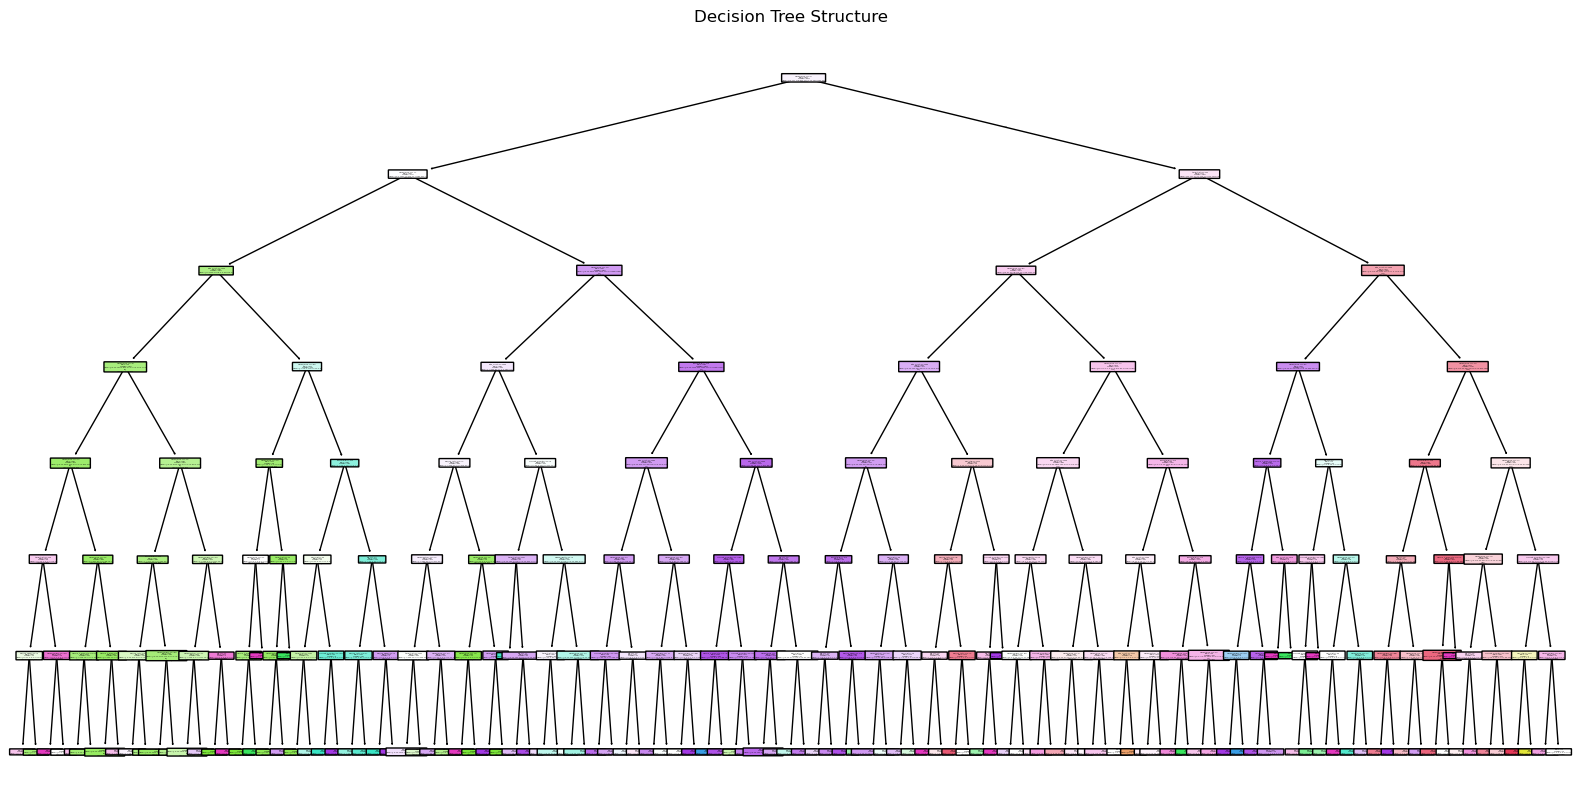


Decision Tree Rules:
|--- verkauf_mean <= 2.06
|   |--- verkauf_mean <= 1.11
|   |   |--- data_sparsity <= 1.00
|   |   |   |--- verkauf_mean <= 0.83
|   |   |   |   |--- verkauf_mean <= 0.41
|   |   |   |   |   |--- stockout_rate <= 0.05
|   |   |   |   |   |   |--- KSR_TSR_Summe <= 0.50
|   |   |   |   |   |   |   |--- class: Nahmias
|   |   |   |   |   |   |--- KSR_TSR_Summe >  0.50
|   |   |   |   |   |   |   |--- class: Bayesian_POS
|   |   |   |   |   |--- stockout_rate >  0.05
|   |   |   |   |   |   |--- verkauf_variance <= 0.35
|   |   |   |   |   |   |   |--- class: Nahmias
|   |   |   |   |   |   |--- verkauf_variance >  0.35
|   |   |   |   |   |   |   |--- class: Bayesian_POS
|   |   |   |   |--- verkauf_mean >  0.41
|   |   |   |   |   |--- verkauf_mean <= 0.60
|   |   |   |   |   |   |--- variance_to_mean_ratio <= 0.55
|   |   |   |   |   |   |   |--- class: Nahmias
|   |   |   |   |   |   |--- variance_to_mean_ratio >  0.55
|   |   |   |   |   |   |   |--- class: Bayes

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.tree import plot_tree, export_text

def analyze_feature_importance(analysis_results, show_plots=True, figsize=(10, 6)):
    """
    Perform comprehensive feature importance analysis on a trained decision tree model.
    
    Parameters:
    -----------
    analysis_results : dict
        Results dictionary returned from analyze_uncensoring_methods()
    show_plots : bool, default=True
        Whether to display matplotlib plots
    figsize : tuple, default=(10, 6)
        Figure size for plots
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'feature_importance_df': DataFrame with feature importances
        - 'permutation_importance_df': DataFrame with permutation importances
        - 'tree_rules': Text representation of decision tree rules
    """
    
    # Extract components from analysis results
    clf = analysis_results['classifier']
    X_test = analysis_results['X_test']
    y_test = analysis_results['y_test']
    feature_names = X_test.columns
    
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*80)
    
    # ============================================================================
    # Method 1: Standard Feature Importance from Decision Tree
    # ============================================================================
    
    feature_importance = clf.feature_importances_
    
    # Create a DataFrame for easier viewing
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("Feature Importance (Decision Tree):")
    print(importance_df.round(4))
    
    # Plot feature importance
    if show_plots:
        plt.figure(figsize=figsize)
        plt.barh(range(len(feature_importance)), feature_importance)
        plt.yticks(range(len(feature_importance)), feature_names)
        plt.xlabel('Feature Importance')
        plt.title('Decision Tree Feature Importance')
        plt.gca().invert_yaxis()  # Most important at top
        plt.tight_layout()
        plt.show()
    
    # ============================================================================
    # Method 2: Permutation Importance
    # ============================================================================
    
    print(f"\nCalculating permutation importance...")
    
    # Calculate permutation importance
    perm_importance = permutation_importance(clf, X_test, y_test, 
                                           n_repeats=10, random_state=42)
    
    # Create DataFrame
    perm_df = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance_mean', ascending=False)
    
    print("\nPermutation Importance:")
    print(perm_df.round(4))
    
    # Plot permutation importance with error bars
    if show_plots:
        plt.figure(figsize=figsize)
        plt.barh(range(len(perm_importance.importances_mean)), 
                 perm_importance.importances_mean,
                 xerr=perm_importance.importances_std)
        plt.yticks(range(len(perm_importance.importances_mean)), feature_names)
        plt.xlabel('Permutation Importance')
        plt.title('Permutation Feature Importance (with std dev)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    # ============================================================================
    # Method 3: Visualize the Decision Tree Structure
    # ============================================================================
    
    if show_plots:
        plt.figure(figsize=(20, 10))
        plot_tree(clf, feature_names=feature_names, 
                  class_names=clf.classes_, filled=True, rounded=True)
        plt.title('Decision Tree Structure')
        plt.show()
    
    # ============================================================================
    # Method 4: Export tree rules (text format)
    # ============================================================================
    
    tree_rules = export_text(clf, feature_names=list(feature_names))
    print("\nDecision Tree Rules:")
    print(tree_rules)
    
    # ============================================================================
    # Summary Analysis
    # ============================================================================
    
    print(f"\nFEATURE IMPORTANCE SUMMARY")
    print("="*80)
    
    # Top 5 most important features (standard importance)
    top_5_standard = importance_df.head(5)
    print("Top 5 Features (Standard Importance):")
    for idx, row in top_5_standard.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")
    
    # Top 5 most important features (permutation importance)
    top_5_perm = perm_df.head(5)
    print("\nTop 5 Features (Permutation Importance):")
    for idx, row in top_5_perm.iterrows():
        print(f"  {row['feature']}: {row['importance_mean']:.4f} ± {row['importance_std']:.4f}")
    
    # Compare the two methods
    print(f"\nFeature Ranking Comparison:")
    print("="*50)
    print("Rank | Standard Method      | Permutation Method")
    print("-" * 50)
    
    for i in range(min(10, len(feature_names))):  # Show top 10 or all if fewer
        standard_feature = importance_df.iloc[i]['feature']
        perm_feature = perm_df.iloc[i]['feature']
        print(f"{i+1:2d}   | {standard_feature:<20} | {perm_feature}")
    
    return {
        'feature_importance_df': importance_df,
        'permutation_importance_df': perm_df,
        'tree_rules': tree_rules
    }


# Then analyze feature importance
features = analyze_feature_importance(analysis)

# Access specific results
top_features = features['feature_importance_df']
permutation_results = features['permutation_importance_df']
decision_rules = features['tree_rules']